In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from models.dcsage import DynamicAdjSAGE
from torch_geometric.data import Data

Global Variables

In [3]:
ANALYSIS_DIR = "2022-04-16-00_41_22"
CONTINENT_ANALYZED = "Eastern Europe"
CONTINENT_NAMES = ["Africa", "North America", "South America", "Oceania", "Eastern Europe", "Western Europe", "Middle East", "South Asia", "Southeast Asia", "Central Asia"]
DATASET_PATH = "/Users/syedrizvi/Desktop/Projects/GNN_Project/DCSAGE/Node-Perturbation/datasets/10_continents_dataset_v19_node_pert.npz"
MODEL_NAME = "DCSAGE"
NUM_MODELS = 100
REC_PRED_LEN = 30
SENSITIVITY_ORDER = ["Western Europe", "North America", "Middle East", "Eastern Europe", "Southeast Asia", "Oceania", "South America", "South Asia", "Africa", "Central Asia"]
SENSITIVITY_ORDER_IDX = [CONTINENT_NAMES.index(SENSITIVITY_ORDER[i]) for i in range(len(SENSITIVITY_ORDER))]
TEST_SET_WINDOW = 500
TRAINING_PATH = "/Users/syedrizvi/Desktop/Projects/GNN_Project/DCSAGE/Training-Code/training-runs-multiple-models/"
TRAINING_RUN = "2022-04-16-00_41_22"
WINDOW_SIZE = 7

## Load dataset

In [4]:
class Covid10CountriesPerturbedDataset(Dataset):
    def __init__(self, dataset_npz_path, SENSITIVITY_ORDER_IDX, window_size=7, data_split="entire-dataset-smooth", load_real_scale=True, perturb_node_steps=[-0.25,0,0,0,0,0,0,0,0,0]):
        avg_graph_structure = False  # Not used here in favor of load_real_scale
        ###########
        # Load data
        ###########
        if data_split == "entire-dataset-smooth" and load_real_scale:  # Need to load real-scaled and log scale later
            feature_matrix = np.load(dataset_npz_path)["feature_matrix_smooth"]
            flight_matrix = np.load(dataset_npz_path)["flight_matrix_unscaled"]
        # elif data_split == "entire-dataset-smooth" and not load_real_scale:
        #     feature_matrix = np.load(dataset_npz_path)["feature_matrix_smooth"]
        #     flight_matrix = np.load(dataset_npz_path)["flight_matrix_log10_scaled"]
        else:
            raise RuntimeError("Unknown dataset split selected")
        
        assert feature_matrix.shape[0] == flight_matrix.shape[0], "Node feature and edge attribute matrices do not match"
        
        ################################################################
        # Perturb chosen country by deleting incoming and outgoing edges
        ################################################################
        removed_cases = 0.
        for node_idx, perturb_step in zip(SENSITIVITY_ORDER_IDX, perturb_node_steps):
            removed_cases += sum(flight_matrix[TEST_SET_WINDOW, node_idx, :] * (1 - (1 + perturb_step)))
            removed_cases += sum(flight_matrix[TEST_SET_WINDOW, :, node_idx] * (1 - (1 + perturb_step)))
            flight_matrix[:, node_idx, :] *= (1 + perturb_step)
            flight_matrix[:, :, node_idx] *= (1 + perturb_step)
        
        print("Cases removed: {}".format(removed_cases))
        
        if load_real_scale:
            flight_matrix = np.log10(flight_matrix, out=np.zeros_like(flight_matrix), where=(flight_matrix > 1))

        self.feature_matrix = feature_matrix
        self.flight_matrix = flight_matrix

        ###############################
        # Create sliding window dataset
        ###############################
        all_window_node_feat = []
        all_window_edge_attr = []
        all_window_edge_idx = []
        all_window_labels = []
        
        for day_idx in range(0, len(feature_matrix) - window_size):
            window_node_feat = []
            window_edge_idx = []
            window_edge_attr = []

            for sub_day in range(day_idx, day_idx + window_size):
                node_data = feature_matrix[sub_day]

                edges_idx_array = np.full((2, 100), -1)
                edges_attr_array = np.full((100), -1).astype(np.float32)
                
                if avg_graph_structure:
                    # Calculate smoothened graph structure across window
                    smoothened_window_flight_matrix = flight_matrix[day_idx: day_idx + window_size].mean(axis=0)  # Shape [10, 10]
                    # Log10 scale now that adjacency is averaged
                    for row in range(len(smoothened_window_flight_matrix)):
                        for col in range(len(smoothened_window_flight_matrix[row])):
                            if smoothened_window_flight_matrix[row][col] > 0:
                                smoothened_window_flight_matrix[row][col] = np.log10(smoothened_window_flight_matrix[row][col])
                    
                    edge_idx = 0
                    for row in range(len(smoothened_window_flight_matrix)):
                        for col in range(len(smoothened_window_flight_matrix[row])):
                            if smoothened_window_flight_matrix[row][col] > 0:
                                edges_idx_array[0][edge_idx] = row  # row is source node
                                edges_idx_array[1][edge_idx] = col  # col is dest node
                                edges_attr_array[edge_idx] = smoothened_window_flight_matrix[row][col]
                                edge_idx += 1
                else:
                    edge_idx = 0
                    for row in range(len(flight_matrix[sub_day])):
                        for col in range(len(flight_matrix[sub_day][row])):
                            if flight_matrix[sub_day][row][col] > 0:
                                edges_idx_array[0][edge_idx] = row
                                edges_idx_array[1][edge_idx] = col
                                edges_attr_array[edge_idx] = flight_matrix[sub_day][row][col]
                                edge_idx += 1
                
                edges_attr_array = np.expand_dims(edges_attr_array, axis=-1)

                window_node_feat.append(np.expand_dims(node_data, axis=0))
                window_edge_idx.append(np.expand_dims(edges_idx_array, axis=0))
                window_edge_attr.append(np.expand_dims(edges_attr_array, axis=0))
            
            window_node_feat = np.concatenate(window_node_feat, axis=0)  # shape (7, 10, 3)
            window_edge_idx = np.concatenate(window_edge_idx, axis=0)  # Shape (7, 2, *num_edges=100)
            window_edge_attr = np.concatenate(window_edge_attr, axis=0)  # Shape (7, *num_edges=100, 1)
            window_labels = feature_matrix[day_idx + window_size, :, 1]  # Shape (10)

            all_window_node_feat.append(np.expand_dims(window_node_feat, axis=0))
            all_window_edge_attr.append(np.expand_dims(window_edge_attr, axis=0))
            all_window_edge_idx.append(np.expand_dims(window_edge_idx, axis=0))
            all_window_labels.append(np.expand_dims(window_labels, axis=0))
        
        self.all_window_node_feat = np.concatenate(all_window_node_feat, axis=0)
        self.all_window_edge_attr = np.concatenate(all_window_edge_attr, axis=0)
        self.all_window_edge_idx = np.concatenate(all_window_edge_idx, axis=0)
        self.all_window_labels = np.concatenate(all_window_labels, axis=0)  # shape (dataset_len, 10)

    def __len__(self):
        return len(self.all_window_labels)
    
    def __getitem__(self, index):
        window_node_feat = self.all_window_node_feat[index].astype(np.float32)  # shape (7, 10, 3)
        window_edge_idx = self.all_window_edge_idx[index]  # shape (7, 2, *num_edges=100)
        window_edge_idx = torch.LongTensor(window_edge_idx)
        window_edge_attr = self.all_window_edge_attr[index]  # shape (7, *num_edges=100, 1)
        window_labels = self.all_window_labels[index]  # shape (10)
        
        return window_node_feat[:,:,1:2], window_edge_idx, window_edge_attr, window_labels

In [5]:
all_dataloaders = []
unpert_dataset = Covid10CountriesPerturbedDataset(
    dataset_npz_path=DATASET_PATH,
    SENSITIVITY_ORDER_IDX=SENSITIVITY_ORDER_IDX,
    window_size=WINDOW_SIZE,
    data_split="entire-dataset-smooth",
    load_real_scale=True,
    perturb_node_steps=[0,0,0,0,0,0,0,0,0,0]
)
unpert_dataloader = DataLoader(unpert_dataset, batch_size=800, shuffle=False)
all_dataloaders.append(unpert_dataloader)

Cases removed: 0.0


In [6]:
first_dataset = Covid10CountriesPerturbedDataset(
    dataset_npz_path=DATASET_PATH,
    SENSITIVITY_ORDER_IDX=SENSITIVITY_ORDER_IDX,
    window_size=WINDOW_SIZE,
    data_split="entire-dataset-smooth",
    load_real_scale=True,
    perturb_node_steps=[0,-1.0,0,0,0,0,0,0,0,0]
)
first_dataloader = DataLoader(first_dataset, batch_size=800, shuffle=False)
all_dataloaders.append(first_dataloader)

Cases removed: 1086.0


In [7]:
second_dataset = Covid10CountriesPerturbedDataset(
    dataset_npz_path=DATASET_PATH,
    SENSITIVITY_ORDER_IDX=SENSITIVITY_ORDER_IDX,
    window_size=WINDOW_SIZE,
    data_split="entire-dataset-smooth",
    load_real_scale=True,
    perturb_node_steps=[0,-0.5,0,0,0,0,0,0,0,0]
)
second_dataloader = DataLoader(second_dataset, batch_size=800, shuffle=False)
all_dataloaders.append(second_dataloader)

Cases removed: 543.0


In [8]:
minimal_change_dataset = Covid10CountriesPerturbedDataset(
    dataset_npz_path=DATASET_PATH,
    SENSITIVITY_ORDER_IDX=SENSITIVITY_ORDER_IDX,
    window_size=WINDOW_SIZE,
    data_split="entire-dataset-smooth",
    load_real_scale=True,
    perturb_node_steps=[0,-0.1,0,0,0,0,0,0,0,0]
)
minimal_change_dataloader = DataLoader(minimal_change_dataset, batch_size=800, shuffle=False)
all_dataloaders.append(minimal_change_dataloader)

Cases removed: 108.6


In [9]:
africa_dataset = Covid10CountriesPerturbedDataset(
    dataset_npz_path=DATASET_PATH,
    SENSITIVITY_ORDER_IDX=SENSITIVITY_ORDER_IDX,
    window_size=WINDOW_SIZE,
    data_split="entire-dataset-smooth",
    load_real_scale=True,
    perturb_node_steps=[0,0,0,0,0,0,0,0,0,-0.5]
)
africa_dataloader = DataLoader(africa_dataset, batch_size=800, shuffle=False)
all_dataloaders.append(africa_dataloader)

Cases removed: 14.0


In [10]:
len(all_dataloaders)

5

Find region in bottom 5 of sensitivity but with similar connectivity to North America

In [11]:
# North America connectivitiy on dataset window
print(unpert_dataset.all_window_edge_attr.shape)
print(unpert_dataset.flight_matrix.shape)

(560, 7, 100, 1)
(567, 10, 10)


In [12]:
# CONTINENT_NAMES = ["Africa", "North America", "South America", "Oceania", "Eastern Europe", "Western Europe", "Middle East", "South Asia", "Southeast Asia", "Central Asia"]
for idx in range(7):
    north_am_outgoing_connections = (unpert_dataset.flight_matrix[TEST_SET_WINDOW + idx, 1,:] > 0).sum()
    north_am_incoming_connections = (unpert_dataset.flight_matrix[TEST_SET_WINDOW + idx, :,1] > 0).sum()
    other_region_outgoing_connections = (unpert_dataset.flight_matrix[TEST_SET_WINDOW + idx, 0,:] > 0).sum()
    other_region_incoming_connections = (unpert_dataset.flight_matrix[TEST_SET_WINDOW + idx, :,0] > 0).sum()
    print("Day {}, NA connections outgoing {} incoming {}, Other connections outgoing {}, incoming {}"
        .format(idx, north_am_outgoing_connections, north_am_incoming_connections, other_region_outgoing_connections, other_region_incoming_connections))

Day 0, NA connections outgoing 8 incoming 8, Other connections outgoing 3, incoming 4
Day 1, NA connections outgoing 7 incoming 7, Other connections outgoing 3, incoming 3
Day 2, NA connections outgoing 8 incoming 8, Other connections outgoing 6, incoming 5
Day 3, NA connections outgoing 8 incoming 8, Other connections outgoing 5, incoming 4
Day 4, NA connections outgoing 8 incoming 8, Other connections outgoing 5, incoming 5
Day 5, NA connections outgoing 8 incoming 8, Other connections outgoing 5, incoming 3
Day 6, NA connections outgoing 8 incoming 8, Other connections outgoing 4, incoming 4


In [13]:
unpert_dataset.flight_matrix[TEST_SET_WINDOW,1,:].sum() + unpert_dataset.flight_matrix[TEST_SET_WINDOW,:,1].sum()

23.329192560353395

In [14]:
unpert_dataset.flight_matrix[TEST_SET_WINDOW,9,:].sum() + unpert_dataset.flight_matrix[TEST_SET_WINDOW,:,9].sum()

3.0492180226701815

In [15]:
unpert_dataset.flight_matrix[TEST_SET_WINDOW, 5:, 5:]

array([[0.        , 2.60638137, 1.11394335, 1.79239169, 0.        ],
       [2.55145   , 0.        , 1.62324929, 1.73239376, 0.69897   ],
       [1.34242268, 1.76342799, 0.        , 1.36172784, 0.        ],
       [1.70757018, 1.62324929, 1.2787536 , 0.        , 0.        ],
       [0.        , 0.90308999, 0.        , 0.        , 0.        ]])

In [16]:
africa_dataset.flight_matrix[TEST_SET_WINDOW, 5:, 5:]

array([[0.        , 2.60638137, 1.11394335, 1.79239169, 0.        ],
       [2.55145   , 0.        , 1.62324929, 1.73239376, 0.39794001],
       [1.34242268, 1.76342799, 0.        , 1.36172784, 0.        ],
       [1.70757018, 1.62324929, 1.2787536 , 0.        , 0.        ],
       [0.        , 0.60205999, 0.        , 0.        , 0.        ]])

## Obtain model predictions on chosen test set window

In [17]:
all_model_predictions = []
for model_idx in range(100):
    if model_idx % 20 == 0:
        print("Processing model {}".format(model_idx))
    ######## Load model checkpoint ########
    model = DynamicAdjSAGE(
        node_features=1, 
        emb_dim=10, 
        window_size=WINDOW_SIZE, 
        output=1, 
        training=True, 
        lstm_type="vanilla", 
        name="DCSAGE"
    )
    checkpoint = torch.load(os.path.join(TRAINING_PATH, TRAINING_RUN, "model_" + str(model_idx) + ".pth"))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    model_predictions = []
    with torch.no_grad():
        for idx, dataloader in enumerate(all_dataloaders):
            overwrite_window_idx = TEST_SET_WINDOW

            ##############################
            # Run recursive testing loop #
            ##############################
            extended_window_ncases = torch.zeros(REC_PRED_LEN + WINDOW_SIZE, 10)  # [37, 10]
            assert dataloader.dataset[overwrite_window_idx][0].shape[2] == 1, "Recursive prediction code made for 1 node feat currently"
            extended_window_ncases[0:WINDOW_SIZE,:] = torch.from_numpy(dataloader.dataset[overwrite_window_idx][0][:,:,0])

            for batch_window_node_feat, batch_window_edge_idx, batch_window_edge_attr, batch_window_labels in dataloader:

                for count, window_idx in enumerate(range(overwrite_window_idx, overwrite_window_idx + REC_PRED_LEN)):
                    window_node_feat = batch_window_node_feat[window_idx]
                    window_edge_idx = batch_window_edge_idx[window_idx]
                    window_edge_attr = batch_window_edge_attr[window_idx]
                    window_labels = batch_window_labels[window_idx]
                    
                    if count > 0:
                        window_node_feat[:,:,0] = extended_window_ncases[count:count + WINDOW_SIZE]

                    h_1, c_1, h_2, c_2 = None, None, None, None
                    for day_idx in range(len(window_node_feat)):
                        day_node_feat = window_node_feat[day_idx]
                        day_edge_idx = window_edge_idx[day_idx]
                        day_edge_attr = window_edge_attr[day_idx]

                        cutoff_idx = day_edge_idx[0].tolist().index(-1)
                        day_edge_idx = day_edge_idx[:, :cutoff_idx]
                        day_edge_attr = day_edge_attr[:cutoff_idx, :]
                        
                        day_graph = Data(x=day_node_feat, edge_index=day_edge_idx, edge_attr=day_edge_attr)
                        y_hat, h_1, c_1, h_2, c_2 = model(day_graph, h_1, c_1, h_2, c_2, day_idx)
                        
                    extended_window_ncases[count + WINDOW_SIZE, :] = y_hat[:,0]
            
            extended_window_ncases = extended_window_ncases[WINDOW_SIZE:,:].numpy()  # [30, 10]
            model_predictions.append(extended_window_ncases)
    all_model_predictions.append(model_predictions)

Processing model 0
Processing model 20
Processing model 40
Processing model 60
Processing model 80


In [18]:
all_model_predictions_np = np.array(all_model_predictions)
print("Shape of final array:", all_model_predictions_np.shape)

Shape of final array: (100, 5, 30, 10)


In [19]:
# Save numpy array
np.save("./100_models_test_set_analysis_predictions", all_model_predictions_np)
print("Done.\n")

Done.



## Apply bias corrections

In [20]:
bias_corrections = np.load("./2022-04-16-00_41_22_bias_corrections.npy")
print(bias_corrections.shape)
bias_corrections

(10,)


array([0.96605238, 1.05199313, 1.04760458, 0.65700955, 1.00581322,
       1.0091801 , 1.00220286, 1.03440618, 0.96381839, 0.87942002])

In [21]:
all_model_predictions_np.shape

(100, 5, 30, 10)

In [22]:
print("Before: Max val is {}".format(all_model_predictions_np.max()))  # about 5.59
# all_model_predictions_np.argmax(axis=3)  # 5, western europe

Before: Max val is 5.781049728393555


In [23]:
for node_idx in range(all_model_predictions_np.shape[3]):
    all_model_predictions_np[:,:,:,node_idx] *= bias_corrections[node_idx]

print("After: Max val is {}".format(all_model_predictions_np.max()))

After: Max val is 6.081624507904053


## Calculate sensitivity scores based on model predictions

In [24]:
all_model_predictions_np.shape
# Index 0 is unperturbed
# Index 1 is 50% reduction
# index 2 is 50% increase

# [100 DCSAGE models, 5 dataloaders, 30 days, 10 node case predictions]

(100, 5, 30, 10)

In [25]:
first_dataset_summed_diffs = np.zeros((all_model_predictions_np.shape[0], all_model_predictions_np.shape[3]))
second_dataset_summed_diffs = np.zeros((all_model_predictions_np.shape[0], all_model_predictions_np.shape[3]))
NA_min_change_summed_diffs = np.zeros((all_model_predictions_np.shape[0], all_model_predictions_np.shape[3]))
AF_summed_diffs = np.zeros((all_model_predictions_np.shape[0], all_model_predictions_np.shape[3]))
AF_summed_diffs.shape

(100, 10)

In [26]:
for model_idx in range(all_model_predictions_np.shape[0]):
    for node_idx in range(10):  # affected geographical region
        if node_idx != 1:  # don't calculate difference in prediction for a region if that region is perturbed
            reduction_difference_list = all_model_predictions_np[model_idx, 1, :, node_idx] - all_model_predictions_np[model_idx, 0, :, node_idx]
            reduction_difference_list = np.abs(reduction_difference_list)  # Unsigned sensitivity
            first_dataset_summed_diffs[model_idx, node_idx] = reduction_difference_list.sum()

            addition_difference_list = all_model_predictions_np[model_idx, 2, :, node_idx] - all_model_predictions_np[model_idx, 0, :, node_idx]
            addition_difference_list = np.abs(addition_difference_list)
            second_dataset_summed_diffs[model_idx, node_idx] = addition_difference_list.sum()

            min_change_difference_list = all_model_predictions_np[model_idx, 3, :, node_idx] - all_model_predictions_np[model_idx, 0, :, node_idx]
            min_change_difference_list = np.abs(min_change_difference_list)
            NA_min_change_summed_diffs[model_idx, node_idx] = min_change_difference_list.sum()
        else:
            first_dataset_summed_diffs[model_idx, node_idx] = 0
            second_dataset_summed_diffs[model_idx, node_idx] = 0
            NA_min_change_summed_diffs[model_idx, node_idx] = 0

        if node_idx != 0:  # Africa perturbed in this dataset, don't include
            africa_difference_list = all_model_predictions_np[model_idx, 4, :, node_idx] - all_model_predictions_np[model_idx, 0, :, node_idx]
            africa_difference_list = np.abs(africa_difference_list)
            AF_summed_diffs[model_idx, node_idx] = africa_difference_list.sum()
        else:
            AF_summed_diffs[model_idx, node_idx] = 0

## Analyze

In [27]:
first_dataset_summed_diffs.shape

(100, 10)

In [28]:
first_dataset_sens_scores = first_dataset_summed_diffs.sum(axis=-1)
second_dataset_sens_scores = second_dataset_summed_diffs.sum(axis=-1)
NA_min_change_sens_scores = NA_min_change_summed_diffs.sum(axis=-1)
AF_sens_scores = AF_summed_diffs.sum(axis=-1)

In [29]:
print(first_dataset_sens_scores.shape)
print(first_dataset_sens_scores.max())
print(first_dataset_sens_scores.min())

(100,)
51.819509506225586
1.2222824096679688


In [30]:
# CONTINENT_NAMES = ["Africa", "North America", "South America", "Oceania", "Eastern Europe", "Western Europe", "Middle East", "South Asia", "Southeast Asia", "Central Asia"]
sensitivty_scores = []
sens_score_type = []

t_test_reduc_score_list = []
t_test_inc_score_list = []

for idx in range(100):
    sensitivty_scores.append(NA_min_change_sens_scores[idx])
    sens_score_type.append(f"NA Minimal Flight Change")
    sensitivty_scores.append(second_dataset_sens_scores[idx])
    sens_score_type.append(f"NA 50% Flight Reduction")
    sensitivty_scores.append(first_dataset_sens_scores[idx])
    sens_score_type.append(f"NA 100% Flight Reduction")
    sensitivty_scores.append(AF_sens_scores[idx])
    sens_score_type.append(f"Central Asia 50% Flight Reduction")
    
    t_test_reduc_score_list.append(first_dataset_sens_scores[idx])
    t_test_inc_score_list.append(second_dataset_sens_scores[idx])

In [31]:
from scipy.stats import ttest_ind

In [32]:
t_statistic, pval = ttest_ind(t_test_reduc_score_list, t_test_inc_score_list)

In [33]:
print("T Test Statistic:", t_statistic)
print("p-value:", pval)

T Test Statistic: 10.196819373758894
p-value: 6.811549050228878e-20


In [34]:
len(sensitivty_scores)

400

In [35]:
# #### Plot distribution of sensitivity scores for both for Eastern Europe ####
visual_df = pd.DataFrame({
    "Sensitivity Score": sensitivty_scores,
    "Perturbation Type": sens_score_type
})

# # sns.displot(data=visual_df, x="Sensitivity Score", hue="Perturbation Type", kind="hist")
# sns.histplot(data=visual_df, x="Sensitivity Score", hue="Perturbation Type", element="step")
# plt.title("North America Sensitivity Scores\nUnder Different Mutations")
# plt.savefig("./test_set_analysis_win500_North_America_histogram.png", bbox_inches="tight", facecolor="white")
# plt.show()

In [36]:
first_dataset_sens_scores.max()

51.819509506225586

In [37]:
sensitivty_scores[0:10]

[0.6217660903930664,
 3.764291524887085,
 9.510363340377808,
 3.224196672439575,
 0.2346053123474121,
 1.8348124027252197,
 6.771812200546265,
 2.3029353618621826,
 1.0157537460327148,
 6.028403997421265]

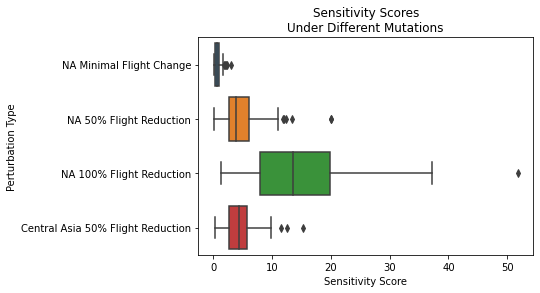

In [38]:
sns.boxplot(data=visual_df, x="Sensitivity Score", y="Perturbation Type")
plt.title("Sensitivity Scores\nUnder Different Mutations")
plt.savefig("./test_set_analysis_NAdec50_CA_dec50percent.png", bbox_inches="tight", facecolor="white")
plt.show()

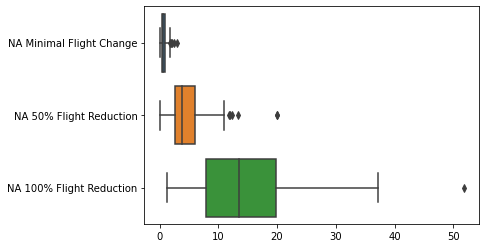

In [42]:
sensitivty_scores = []
sens_score_type = []

for idx in range(100):
    sensitivty_scores.append(NA_min_change_sens_scores[idx])
    sens_score_type.append(f"NA Minimal Flight Change")
    sensitivty_scores.append(second_dataset_sens_scores[idx])
    sens_score_type.append(f"NA 50% Flight Reduction")
    sensitivty_scores.append(first_dataset_sens_scores[idx])
    sens_score_type.append(f"NA 100% Flight Reduction")

visual_df = pd.DataFrame({
    "Sensitivity Score": sensitivty_scores,
    "Perturbation Type": sens_score_type
})

sns.boxplot(data=visual_df, x="Sensitivity Score", y="Perturbation Type")
plt.xlabel(None)
plt.ylabel(None)
plt.savefig("./test_set_analysis_NA_steps.png", bbox_inches="tight", facecolor="white", dpi=300)
plt.show()